In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

batch = 100
inputImageSize = 28 * 28
NoClasses = 10 # system dziesiątkowy
learning_rate = 0.001

In [22]:
# Pobranie danych
trainigSet = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

tesingSet = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=False,
    transform=transforms.ToTensor()
)

# Ładowanie danych
trainLoader = DataLoader(trainigSet, batch_size=batch, shuffle=True)
testLoader = DataLoader(tesingSet, batch_size=batch, shuffle=True)

In [23]:
# Tworzenie sieci

class ExtractFeaturesModel(nn.Module):
    def __init__(self):
        super(ExtractFeaturesModel, self).__init__()
        self.l1 = nn.Linear(28 * 8, 84)
        self.l2 = nn.Linear(84, 42)
        self.l3 = nn.Linear(42, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.extractFeatures(x)
        out = self.relu(self.l1(x))
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out
    
    def extractFeatures(self, x):
        x = x.view(-1, 28, 28)
        maxV, maxI = torch.max(x, 1)
        minV, minI = torch.min(x, 1)
        medV1, medI1 = torch.median(x, dim=1)
        medV2, medI2 = torch.median(x, dim=2)
        return torch.concat([maxV, maxI, minV, minI, medV1, medI1, medV2, medI2], dim=1)

model = ExtractFeaturesModel()

# Wybór optimizera i funkcji błędu
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

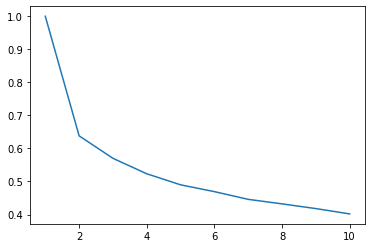

In [24]:
# Trenowanie sieci
noEpochs = 10
prev_epoch = 1
loss_vals=  []
for epoch in range(noEpochs):

    epoch_loss= []

    for images, labels in trainLoader:

        # forwad pass
        result = model.forward(images)
        loss = criterion(result, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

plt.plot(np.linspace(1, noEpochs, noEpochs).astype(int), loss_vals)


Czas potrzebny 1m 48,7s
Trening na CPU: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz   2.30 GHz
Pamięć RAM 16,00 GB


In [25]:
# Testowanie modelu
with torch.no_grad():
    correctPredictions = 0
    numberOfSamples = 0
    for i, (samples, labels) in enumerate(testLoader):
        samples = samples.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # propagacja
        outputs = model(samples)
        _, predictions = torch.max(outputs, 1)
        numberOfSamples += labels.shape[0]
        correctPredictions += (predictions == labels).sum().item()

    # obliczenie skuteczności
    accuracy = 100 * correctPredictions / numberOfSamples
    print('accuracy:', accuracy)


accuracy: 86.31


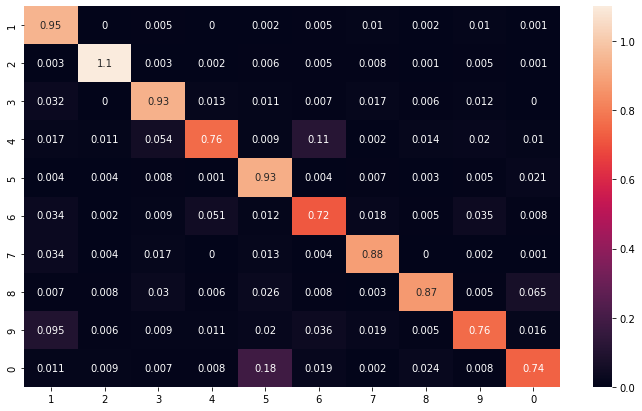

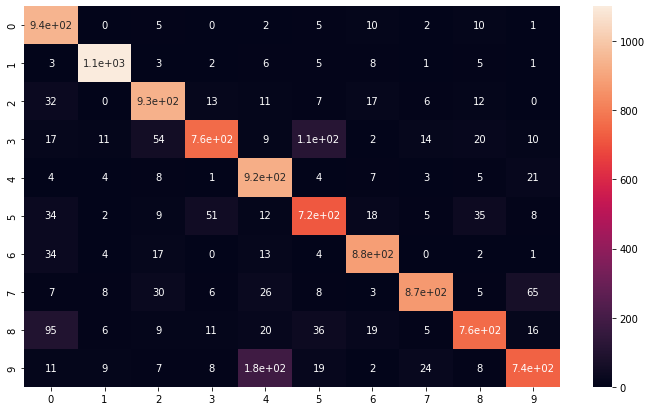

In [26]:
# Confusion Matrix

pred = []
act = []

for samples, labels in testLoader:
    samples = samples.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrame.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrix.png')

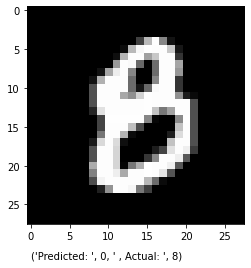

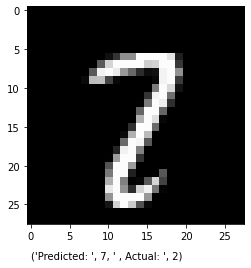

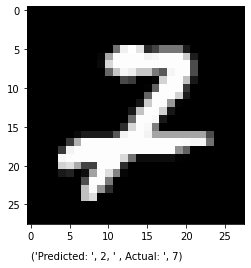

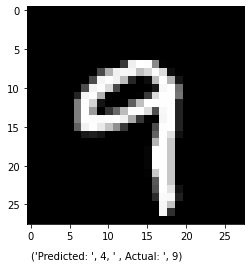

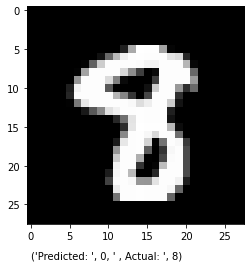

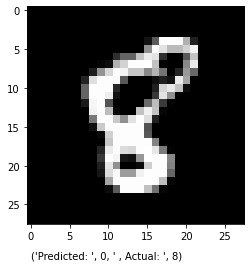

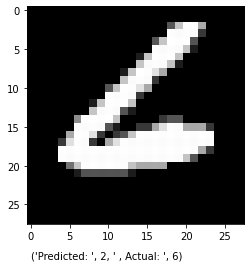

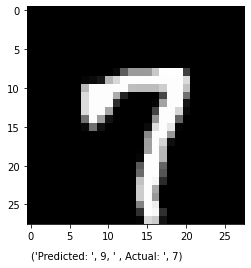

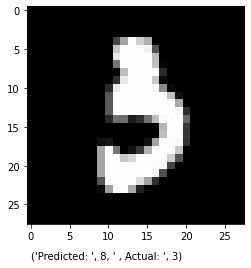

In [27]:
# Przykłady złej klasyfikacji
for i, (samples, labels) in enumerate(testLoader):
    samples = samples.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

    if output[i] != labels[i]:
        text = 'Predicted: ', output[i], ' , Actual: ', labels[i]
        plt.figure()
        plt.imshow(samples[i].reshape(28,28), cmap="gray")
        plt.text(0, 32, text)

In [28]:
# zapisywanie
torch.save(model.state_dict(), 'featExp_model.pth')

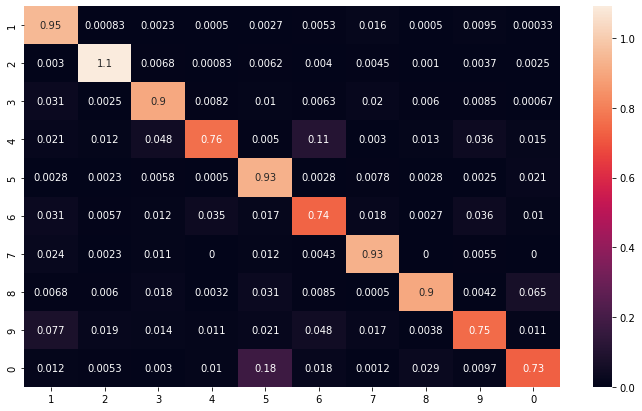

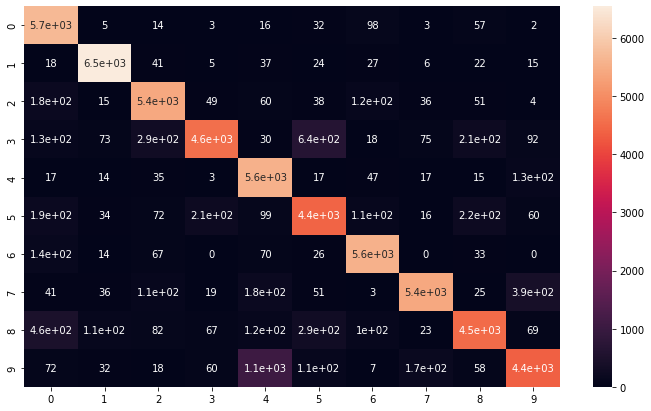

In [29]:
# Confusion Matrix treningowy


pred = []
act = []

for samples, labels in trainLoader:
    samples = samples.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrameTrain.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrixTrain.png')